# Install or upgrade libraries

It might be that you are running with the latest libraries and that they all work together fine.

Running the following cell takes a minute or so but ensures that you have a consistent set of python tools.

In [1]:
import sys
print(f"{sys.version = }\n")


sys.version = '3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]'



In [2]:
# If there are issues with fsspect-xrootd not being found, run this outside of Jupyter-notebook and restart
# !pip install --upgrade fsspec-xrootd

In [3]:
#'''
!pip install --upgrade pip

!pip install futures

!pip install --user --upgrade coffea

!pip install --upgrade awkward
!pip install --upgrade uproot

!pip install --upgrade fsspec-xrootd

!pip install vector

!pip install --upgrade pandas


!pip install --upgrade matplotlib
#'''

We've also prepared some helper code that makes it easier to work with the data in this lesson.

You can see the code [here](https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py) but we will explain the functions and data objects in this notebook.

Let's download it first.

In [4]:
#!wget https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py

## Imports

Import all the libraries we will need and check their versions, in case you run into issues.

In [5]:
%load_ext autoreload
%autoreload 2

# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

import requests
import os

import time

import json

import dpoa_workshop_utilities
from dpoa_workshop_utilities import nanoaod_filenames
from dpoa_workshop_utilities import get_files_for_dataset
from dpoa_workshop_utilities import pretty_print
from dpoa_workshop_utilities import build_lumi_mask

import sys

In [6]:
print("Versions --------\n")
print(f"{sys.version = }\n")
print(f"{ak.__version__ = }\n")
print(f"{uproot.__version__ = }\n")
print(f"{np.__version__ = }\n")
print(f"{matplotlib.__version__ = }\n")
print(f"{vector.__version__ = }\n")
print(f"{pd.__version__ = }\n")

Versions --------

sys.version = '3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]'

ak.__version__ = '2.8.3'

uproot.__version__ = '5.6.2'

np.__version__ = '2.2.6'

matplotlib.__version__ = '3.10.3'

vector.__version__ = '1.6.2'

pd.__version__ = '2.3.0'



# Opening a file

Let's open and explore a sample file.

We'll be getting the data from [here](https://opendata.cern.ch/record/67993).

This is some Monte Carlo that contains simulations of a top-antitop pair being created in a proton-proton collision at CMS.

One top decays leptonically and the other decays hadronically.

**Do you know what leptonically and hadronically mean? If not, do a bit of research.**

When you go to open the file, it might take 10-30 seconds at this step if you are working with the larger file.

In [7]:
# For testing
# Big file
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

# Smaller file, better for prototyping your code as things will run faster
filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

# print(f"Opening...{filename}")
# f = uproot.open(filename)

# events = f['Events']

# nevents = events.num_entries

# print(f"{nevents = }")

The `events` object is a `TTree` implementation in python and behaves like a dictionary. This means
we can get all the keys if we want.

In [8]:
# Uncomment the following line to print all the keys

#print(events.keys())

Again, we have provided you with a helper function called `pretty_print` that will print subsets of the keys, based on strings
that you require or ignore.

It will also format that output based on how many characters you want in a column (you are limited to 80 characters per line).

Here is some example usage.

In [9]:
# Pretty print all the keys with the default format
#pretty_print(events.keys())

# Pretty print keys with 30 characters per column, for keys that contain `FatJet`
#pretty_print(events.keys(), fmt='30s', require='FatJet')

# Pretty print keys with 40 characters per column, for keys that contain `Muon` and `Iso` but ignore ones with `HLT`
#pretty_print(events.keys(), fmt='40s', require=['Muon'], ignore='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `HLT` and `TkMu50`
#pretty_print(events.keys(), fmt='40s', require=['HLT', 'TkMu50'])

# Pretty print keys with 40 characters per column, for keys that contain `HLT`
#pretty_print(events.keys(), fmt='40s', require='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `Jet_` but ignore ones with `Fat`
#pretty_print(events.keys(), fmt='40s', require='Jet_', ignore='Fat')

# Pretty print keys with 40 characters per column, for keys that contain `PuppiMET` but ignore ones with `Raw`
#pretty_print(events.keys(), fmt='40s', require='PuppiMET', ignore='Raw')

## Extract some data

We're going to pull out subsets of the data in order to do our analysis.

As a reminder, you can find a list of the variable names in each dataset on the CERN Open Data Portal page for that dataset, for example, [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/75156/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8_doc.html).

We're going to work with the following sets of variables
* `FatJet` for jets that are merges
* `Jet` for non-merged jets
* `Muon` for muons
* `PuppiMET` which is missing energy in the transverse plane (MET) for pileup per particle identification (Puppi)

Running this cell might take a little bit if you are running over the bigger file. However, once you pull out the values, later calculations are much faster.

In [10]:
# # Jets ---------------------------------------------------
# # B-tagging variable
# jet_btag = events['Jet_btagDeepB'].array()

# # Measure of quality of measurement of jet
# jet_jetid = events['Jet_jetId'].array()

# # 4-momentum in pt, eta, phi, mass
# jet_pt = events['Jet_pt'].array()
# jet_eta = events['Jet_eta'].array()
# jet_phi = events['Jet_phi'].array()
# jet_mass = events['Jet_mass'].array()


# # Muons ---------------------------------------------------
# # Muon isolation
# muon_iso = events['Muon_miniIsoId'].array()

# # Measure of quality of how well the muon is reconstructed
# muon_tightId = events['Muon_tightId'].array()

# # 4-momentum in pt, eta, phi, mass
# muon_pt = events['Muon_pt'].array()
# muon_eta = events['Muon_eta'].array()
# muon_phi = events['Muon_phi'].array()
# muon_mass = events['Muon_mass'].array()


# # MET ------------------------------------------------------
# # 3-momentum in pt, eta, phi, mass
# met_pt = events['PuppiMET_pt'].array()
# met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
# met_phi = events['PuppiMET_phi'].array()

# What comes next?

In [11]:
def process_file(filename):
    """
    Root file processing function;
    
    ############################
    ########## INPUTS ##########
    ############################
    
    filename (str, default=None) - Full root file destination

    #############################
    ########## RETURNS ##########
    #############################
    
    events (uproot.model (Tree)) - Root file keys
    """
    ############################################
    ########## OPENING SPECIFIED FILE ##########
    ############################################
    print(f"Opening...{filename}")
    
    try:
        f = uproot.open(filename)
    except:
        print(f"Could not open {filename}")
        return None

    ####################################################################
    ########## ACCESSING EVENTS AND MAKING SPECIFIC VARIABLES ##########_jet_cut
    ####################################################################
    
    events = f['Events']

    nevents = events.num_entries

    print(f"{nevents = }")


    
    return events

def plot_func(events, pt_cut_vals=[0], btag_cut="none"):
    """
    Plotting Function

    Plots histograms of Jet and Muon Transverse Momentum and respective numbers
    
    ############################
    ########## INPUTS ##########
    ############################
    
    events_keys (uproot.model (Tree), default=None) - Root file keys; Can be entered to skip re-processing of root file
    
    plot (bool, default=False) - Calls plotting function if set to True
    
    cut_vals (int/float list, default=[0]) - Transverse momentum cut values
    
    btag_cut (str, default="none") - None, Loose, Medium, Tight cut using Jet_btagDeepB and Jet_btagDeepFlavB

    #############################
    ########## RETURNS ##########
    #############################

    None.
    """
    
    ################################################
    ########## VARIABLES FROM EVENTS FILE ##########
    ################################################
    
    # Muons -------------------------------------------------------
    muon_pt = events['Muon_pt'].array()
    # muon_eta = events['Muon_eta'].array()
    # muon_phi = events['Muon_phi'].array()
    # muon_mass = events['Muon_mass'].array()

    # muon_iso = events['Muon_miniIsoId'].array()

    # muon_tightId = events['Muon_tightId'].array()

    
    # Jets -------------------------------------------------------
    jet_btag = events['Jet_btagDeepB'].array()
    # jet_jetid = events['Jet_jetId'].array()

    jet_pt = events['Jet_pt'].array()
    # jet_eta = events['Jet_eta'].array()
    # jet_phi = events['Jet_phi'].array()
    # jet_mass = events['Jet_mass'].array()

    ###################################
    ########## APPLYING CUTS ##########
    ###################################

    for cut in pt_cut_vals:
        pt_jet_cut = jet_pt > cut
        
        ## B-Tagging ----------------------------------------------------
        if btag_cut == "tight" or btag_cut == "Tight":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.8767
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.6377
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        elif btag_cut == "medium" or btag_cut == "Medium":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.5847
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.2489
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        elif btag_cut == "loose" or btag_cut == "Loose":
            deep_b_tag = events["Jet_btagDeepB"].array() > 0.1918
            deep_flavb_tag = events["Jet_btagDeepFlavB"].array() > 0.0480
            btag = deep_b_tag & deep_flavb_tag

            cut_jets = jet_pt[pt_jet_cut[btag]]

        else:
            cut_jets = jet_pt[pt_jet_cut]

        
        pt_muon_cut = muon_pt > cut
        cut_muons = muon_pt[pt_muon_cut]

        ##############################
        ########## PLOTTING ##########
        ##############################
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5), tight_layout=True)
        
        fig.text(0.27,0.92, f"Jets : $p_T$>{cut} (GeV/$c$) | BTag: {btag_cut}", ha='center', fontsize=18)
        fig.text(0.77, 0.92, f"Muons : $p_T$>{cut} (GeV/$c$)", ha='center', fontsize=18)
        
        ## Jets -------------------------------------------------------------
        ax1.hist(ak.flatten(cut_jets), 
                 bins=100,label=f"Number of Jets:{ak.sum(ak.num(cut_jets))}",
                range=(0,400))
        ax1.set_xlabel("Transverse Momentum",fontsize=14)
        ax1.set_ylabel("Counts",fontsize=14)
        ax1.legend()

        ax2.hist(ak.num(cut_jets), 
                 bins=100,label=f"Number of Jets:{ak.sum(ak.num(cut_jets))}",
                range=(0,10))
        ax2.set_xlabel("Number of Jets",fontsize=14)
        #ax2.set_ylabel("Counts")
        #ax2.title(f"Jets : $p_T$>{cut} (GeV/$c$)")
        ax2.legend()

        ## Muons --------------------------------------------------------------
        ax3.hist(ak.flatten(cut_muons), 
                 bins=100,label=f"Number of Muons:{ak.sum(ak.num(cut_muons))}",
                range=(0,400), color="darksalmon")
        ax3.set_xlabel("Transverse Momentum",fontsize=14)
        #ax3.set_ylabel("Counts")
        ax3.legend()

        ax4.hist(ak.num(cut_muons), 
                 bins=100,label=f"Number of Muons:{ak.sum(ak.num(cut_muons))}",
                range=(0,5), color="darksalmon")
        ax4.set_xlabel("Number of Muons",fontsize=14)
        #ax4.set_ylabel("Counts")
        #ax4.title(f"Muons : $p_T$>{cut} (GeV/$c$)")
        ax4.legend()

        plt.tight_layout(rect=[0,0,1,0.93])

def main(filename=None, events_keys=None, plot=False, pt_cut_vals=[0], btag_cut="none"):
    """
    Main calling function for process_file and plot_func functions
    
    ############################
    ########## INPUTS ##########
    ############################
    
    filename (str, default=None) - Full root file destination
    
    events_keys (uproot.model (Tree), default=None) - Root file keys; Can be entered to skip re-processing of root file
    
    plot (bool, default=False) - Calls plotting function if set to True
    
    cut_vals (int/float list, default=[0]) - Transverse momentum cut values
    
    btag_cut (str, default="none") - None, Loose, Medium, Tight cut using Jet_btagDeepB and Jet_btagDeepFlavB

    #############################
    ########## RETURNS ##########
    #############################
    
    events (uproot.model (Tree)) - Root file keys
    """

    if events_keys is None:
        events = process_file(filename)

    elif events_keys is not None:
        events = events_keys
    
    if plot == True:
        plot_func(events, pt_cut_vals, btag_cut);

    return events

In [12]:
events = main(filename)

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000


In [13]:
jet_pt = events["Jet_pt"].array()
muon_pt = events["Muon_pt"].array()
print(f"Number of jets: {len(ak.flatten(jet_pt))}")
print(f"Number of muons: {len(ak.flatten(muon_pt))}")

Number of jets: 1247966
Number of muons: 151820


In [14]:
cut_vals = [10, 20, 25, 30]
# Smaller file, better for prototyping your code as things will run faster
small_file = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'
#events = main(filename, plot=True, cut_vals=cut_vals)

In [15]:
# Big file
big_file = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

In [16]:
small_events = main(small_file)
big_events = main(big_file)

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000
Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root
nevents = 1233000


<TTree 'Events' (1504 branches) at 0x7f5df5340710>

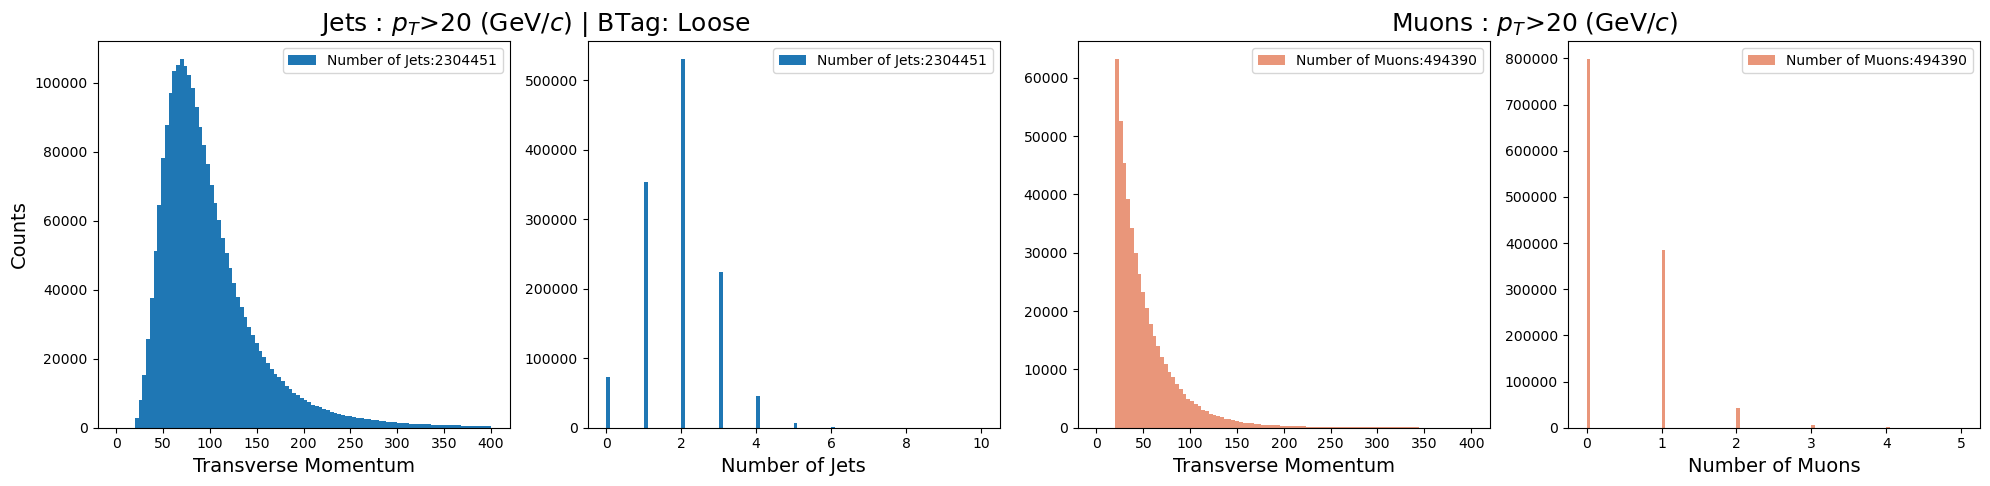

In [17]:
main(events_keys=big_events, pt_cut_vals=[20], btag_cut="Loose", plot=True)

<TTree 'Events' (1504 branches) at 0x7f5df5340710>

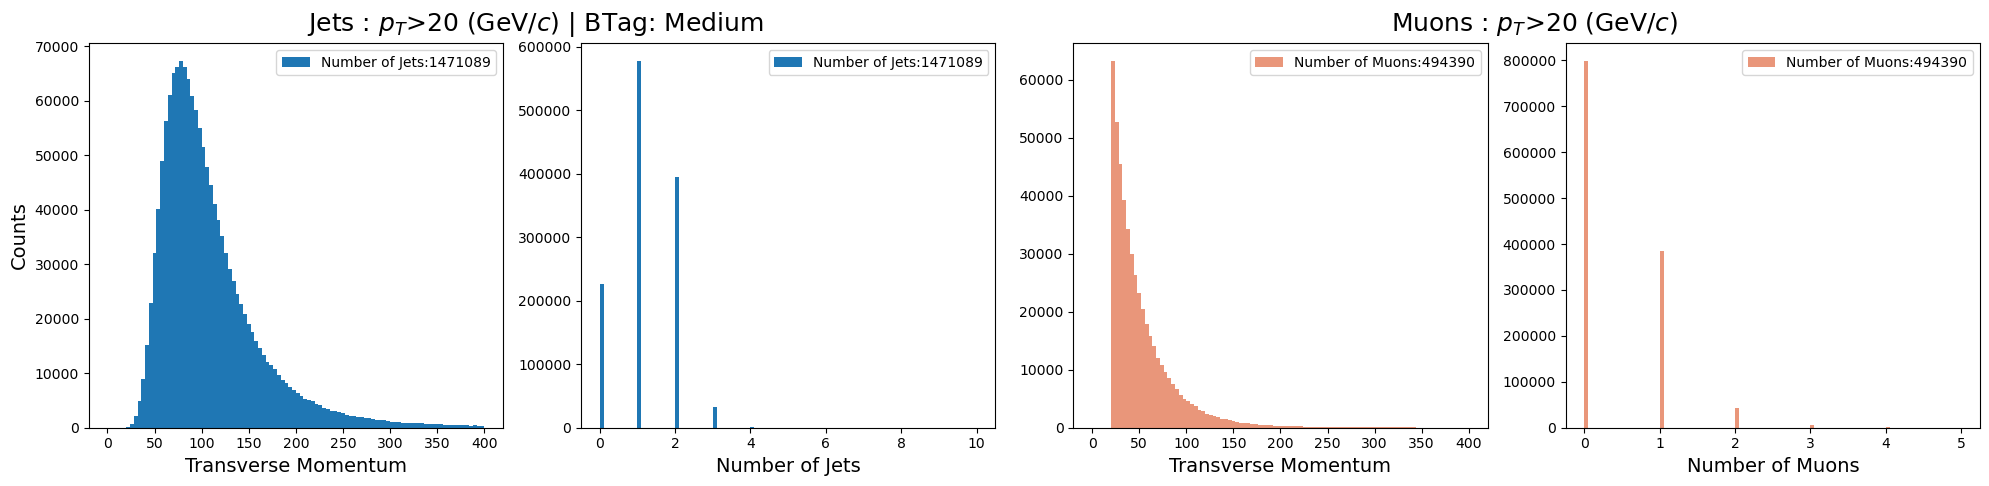

In [18]:
main(events_keys=big_events, pt_cut_vals=[20], btag_cut="Medium", plot=True)

<TTree 'Events' (1504 branches) at 0x7f5df5340710>

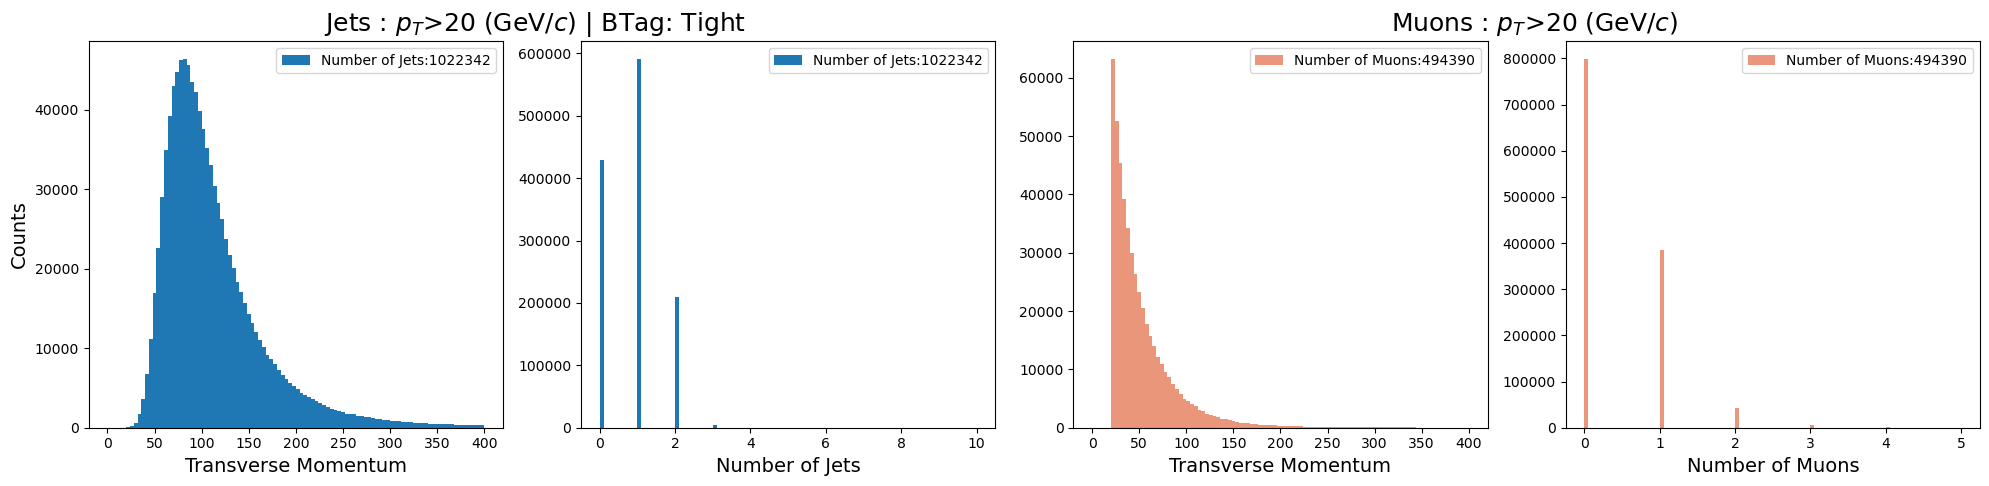

In [19]:
main(events_keys=big_events, pt_cut_vals=[20], btag_cut="Tight", plot=True)

In [20]:
jet_btagB = big_events["Jet_btagDeepB"].array()
jet_btag_flavB = big_events["Jet_btagDeepFlavB"].array()
x_vals = {
    "Loose": [0.1918, 0.0480, "purple"],
    "Medium": [0.5847, 0.2489, "yellow"],
    "Tight": [0.8767, 0.6377, "red"]
}

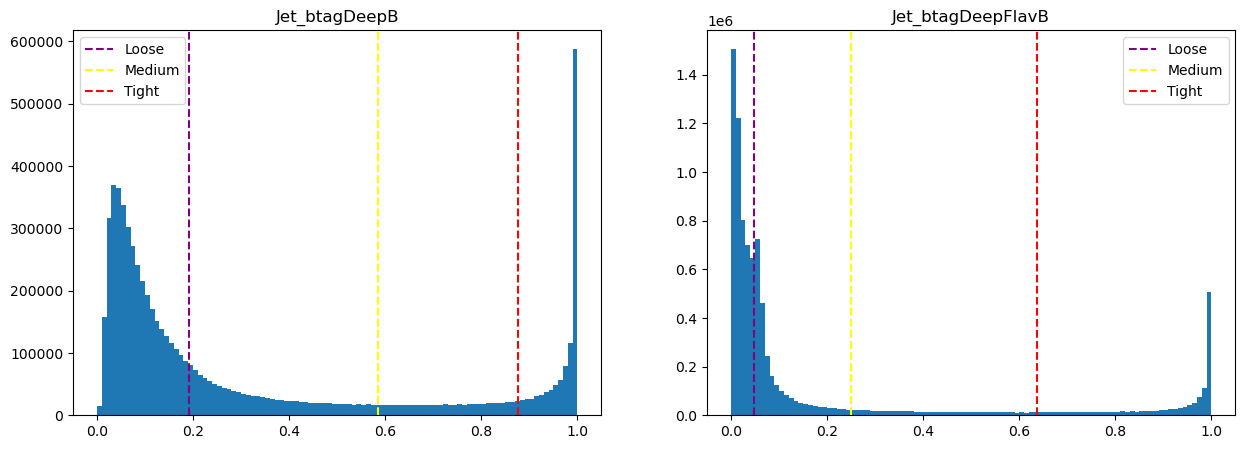

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.hist(ak.flatten(jet_btagB), bins=100, range=(0,1));
for val in x_vals:
    plt.axvline(x_vals[val][0], color=x_vals[val][-1], linestyle='--', label=val)
plt.title("Jet_btagDeepB")
plt.legend();

plt.subplot(1,2,2)

plt.hist(ak.flatten(jet_btag_flavB), bins=100, range=(0,1));
for val in x_vals:
    plt.axvline(x_vals[val][1], color=x_vals[val][-1], linestyle='--', label=val)
plt.title("Jet_btagDeepFlavB")
plt.legend();

# Invariant Mass of Top Quark and W Boson

In [22]:
events = big_events

In [23]:
pretty_print(events.keys(), fmt='40s', require=['Muon'], ignore='HLT')

Jet_nMuons                               L1PreFiringWeight_Muon_Nom               
L1PreFiringWeight_Muon_StatDn            L1PreFiringWeight_Muon_StatUp            
L1PreFiringWeight_Muon_SystDn            L1PreFiringWeight_Muon_SystUp            
nMuon                                    Muon_dxy                                 
Muon_dxyErr                              Muon_dxybs                               
Muon_dz                                  Muon_dzErr                               
Muon_eta                                 Muon_ip3d                                
Muon_jetPtRelv2                          Muon_jetRelIso                           
Muon_mass                                Muon_miniPFRelIso_all                    
Muon_miniPFRelIso_chg                    Muon_pfRelIso03_all                      
Muon_pfRelIso03_chg                      Muon_pfRelIso04_all                      
Muon_phi                                 Muon_pt                                  
Muon

In [245]:
start_time = time.time()

# # FatJet -----------------------------------------------------
# fatjet_mSD = events['FatJet_msoftdrop'].array()

# fatjet_tag = events['FatJet_particleNet_TvsQCD'].array()

# fatjet_tau2 = events['FatJet_tau2'].array()
# fatjet_tau3 = events['FatJet_tau3'].array()

# fatjet_pt = events['FatJet_pt'].array()
# fatjet_eta = events['FatJet_eta'].array()
# fatjet_phi = events['FatJet_phi'].array()
# fatjet_mass = events['FatJet_mass'].array()

# print(f"It took {time.time() - start_time:.2f} seconds to access FatJet")

# Muons -------------------------------------------------------
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()

muon_iso = events['Muon_miniIsoId'].array()

muon_tightId = events['Muon_tightId'].array()

print(f"It took {time.time() - start_time:.2f} seconds to access Muons")
    
# Jets -------------------------------------------------------
jet_btag = events['Jet_btagDeepB'].array()
jet_jetid = events['Jet_jetId'].array()

jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()
jets_btagDeepB = events["Jet_btagDeepB"].array()
jets_btagDeepFlavB = events["Jet_btagDeepFlavB"].array()

print(f"It took {time.time() - start_time:.2f} seconds to access Jets")

# MET ---------------------------------------------------------
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array() 

ht_lep = muon_pt + met_pt

print(f"It took {time.time() - start_time:.2f} seconds to access MET")

######################################
print(f"It took {time.time() - start_time:.2f} seconds to access all this data")

It took 31.72 seconds to access Muons
It took 138.05 seconds to access Jets
It took 151.84 seconds to access Muons
It took 151.84 seconds to access all this data


In [26]:
    ##########################
    ########## CUTS ##########
    ##########################

# # Particle-specific cuts --------------------------------------
# tau32 = fatjet_tau3/fatjet_tau2

# #cut_fatjet = (tau32>0.67) & (fatjet_eta>-2.4) & (fatjet_eta<2.4) & (fatjet_mSD>105) & (fatjet_mSD<220)
# cut_fatjet = (fatjet_pt > 500) & (fatjet_tag > 0.5)

# cut_muon = (muon_pt>20) & (muon_eta>-2.4) & (muon_eta<2.4) & \
#            (muon_tightId == True) & (muon_iso>1) & (ht_lep>150)

# cut_jet = (jet_btag > 0.5) & (jet_jetid>=4)
# # Event cuts -------------------------------------------------
# cut_met = (met_pt > 50)

# cut_nmuons = ak.num(cut_muon[cut_muon]) == 1
# cut_njets = ak.num(cut_jet[cut_jet]) == 4


# cut_trigger = (events['HLT_TkMu50'].array())
    
# cut_ntop = ak.num(cut_fatjet[cut_fatjet]) == 1

# cut_full_event = cut_trigger & cut_nmuons# & cut_met & cut_ntop
        
# #############################################
# ########## CALCULATING DI-TOP MASS ##########
# #############################################
    
# fatjets = ak.zip(
#     {"pt": fatjet_pt[cut_full_event][cut_fatjet[cut_full_event]], 
#      "eta": fatjet_eta[cut_full_event][cut_fatjet[cut_full_event]], 
#      "phi": fatjet_phi[cut_full_event][cut_fatjet[cut_full_event]], 
#      "mass": fatjet_mass[cut_full_event][cut_fatjet[cut_full_event]]},
#     with_name="Momentum4D",
# )

# muons = ak.zip(
#     {"pt": muon_pt[cut_full_event][cut_muon[cut_full_event]], 
#      "eta": muon_eta[cut_full_event][cut_muon[cut_full_event]], 
#      "phi": muon_phi[cut_full_event][cut_muon[cut_full_event]], 
#      "mass": muon_mass[cut_full_event][cut_muon[cut_full_event]]},
#     with_name="Momentum4D",
# )

# jets = ak.zip(
#     {"pt": jet_pt[cut_full_event][cut_jet[cut_full_event]], 
#      "eta": jet_eta[cut_full_event][cut_jet[cut_full_event]], 
#      "phi": jet_phi[cut_full_event][cut_jet[cut_full_event]], 
#      "mass": jet_mass[cut_full_event][cut_jet[cut_full_event]],
#      "btagCSVV2": jets_btagCSVV2[cut_full_event][cut_jet[cut_full_event]]},
#     with_name="Momentum4D",
# )

# met = ak.zip(
#     {"pt": met_pt[cut_full_event], 
#      "eta": met_eta[cut_full_event], 
#      "phi": met_phi[cut_full_event], 
#      "mass": 0}, # We assume this is a neutrino with 0 mass
#     with_name="Momentum4D",
# )
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
fatjets = ak.zip(
    {"pt": fatjet_pt, 
     "eta": fatjet_eta, 
     "phi": fatjet_phi, 
     "mass": fatjet_mass},
    with_name="Momentum4D",
)

muons = ak.zip(
    {"pt": muon_pt, 
     "eta": muon_eta, 
     "phi": muon_phi, 
     "mass": muon_mass},
    with_name="Momentum4D",
)

jets = ak.zip(
    {"pt": jet_pt, 
     "eta": jet_eta, 
     "phi": jet_phi, 
     "mass": jet_mass,
     "btagDeepB": jets_btagDeepB,
     "btagDeepFlavB": jets_btagDeepFlavB},
    with_name="Momentum4D",
)

met = ak.zip(
    {"pt": met_pt, 
     "eta": met_eta, 
     "phi": met_phi, 
     "mass": np.zeros(len(met_phi))}, # We assume this is a neutrino with 0 mass
    with_name="Momentum4D",
)

In [27]:
# Calculate all the different combinations
p4mu,p4fj,p4j,p4met = ak.unzip(ak.cartesian([muons, fatjets, jets, met]))

# Calculate a sum of the 4-momenta
p4tot = p4mu + p4fj + p4j + p4met

[[], [], [], [], [], ..., [324, 411, 336, ..., 307, 277, 262], [], [], [], []]


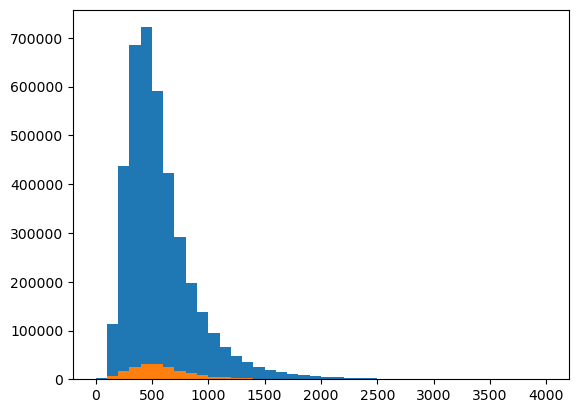

In [28]:
# Get the mass
x = p4tot.mass

print(x)

#ncand_cut = ak.num(x)==1
ncand_cut = ak.num(x)>0

# Plot it!
# Your code here
plt.figure()
plt.hist(ak.flatten(x[ncand_cut]), bins=40, range=(0,4000));
plt.hist(x[ncand_cut][:,0], bins=40, range=(0,4000));

In [542]:
#########################################################################
##################### SELECTING DESIRED DATA (CUTS) #####################
#########################################################################

muon_mask = (muons.pt > 20) & (np.abs(muons.eta) < 2.1)
jet_mask = (jets.pt > 20) & (np.abs(jets.eta) < 2.4)

cut_muons = muons[muon_mask]
cut_jets = jets[jet_mask]

n_muons = ak.num(cut_muons)
n_jets = ak.num(cut_jets)
n_bjets = ak.sum(jets.btagDeepB > 0.8767, axis=1)

event_mask = (n_muons >= 1) & (n_jets == 4) & (n_bjets == 2)

selected_jets = cut_jets[event_mask]
selected_muons = cut_muons[event_mask]

#################################################################
##################### TOP QUARK CALCULATION #####################
#################################################################

btag_cut = 0.8767
non_btag_cut = 0.3

trijets = ak.combinations(selected_jets, 3, fields=["j1","j2","j3"])
trijets["p4"] = trijets.j1 + trijets.j2 + trijets.j3 # Sum of 4-momenta

mask_jets_btag = ((trijets.j1.btagDeepB > btag_cut) & (trijets.j2.btagDeepB < non_btag_cut) & (trijets.j3.btagDeepB < non_btag_cut)) | \
                 ((trijets.j1.btagDeepB < non_btag_cut) & (trijets.j2.btagDeepB > btag_cut) & (trijets.j3.btagDeepB < non_btag_cut)) | \
                 ((trijets.j1.btagDeepB < non_btag_cut) & (trijets.j2.btagDeepB < non_btag_cut) & (trijets.j3.btagDeepB > btag_cut))

top_trijet = trijets.p4[mask_jets_btag][ak.argmax(trijets.p4.pt[mask_jets_btag], axis=1, keepdims=True)]
invmass_top = ak.flatten(top_trijet.mass)

###############################################################
##################### W BOSON CALCULATION #####################
###############################################################

event_mask = (n_muons >= 1) & (n_jets == 4)

selected_jets = cut_jets[event_mask]
selected_muons = cut_muons[event_mask]

dijets = ak.combinations(selected_jets, 2, fields=["j1","j2"])
dijets["p4"] = dijets.j1 + dijets.j2


non_mask_jets_btag = ((dijets.j1.btagDeepB < btag_cut) & (dijets.j2.btagDeepB < btag_cut))


dijets_nb = dijets[non_mask_jets_btag]
mass_dif = abs(dijets_nb.p4.mass - 80.4)
w_cand_had2 = dijets_nb.p4[ak.argmin(mass_dif, axis = 1, keepdims=True)]
invmass_w2 = ak.flatten(w_cand_had2.mass)

w_cand_had = dijets.p4[non_mask_jets_btag][ak.argmax(dijets.p4.pt[non_mask_jets_btag], axis=1, keepdims=True)]
invmass_w = ak.flatten(w_cand_had.mass)



(array([9.02000e+03, 6.46430e+04, 2.01129e+05, 3.23091e+05, 2.99272e+05,
        1.89006e+05, 9.13790e+04, 3.67450e+04, 1.29890e+04, 4.11200e+03,
        1.18600e+03, 3.08000e+02, 8.70000e+01, 2.50000e+01, 6.00000e+00]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5]),
 <BarContainer object of 15 artists>)

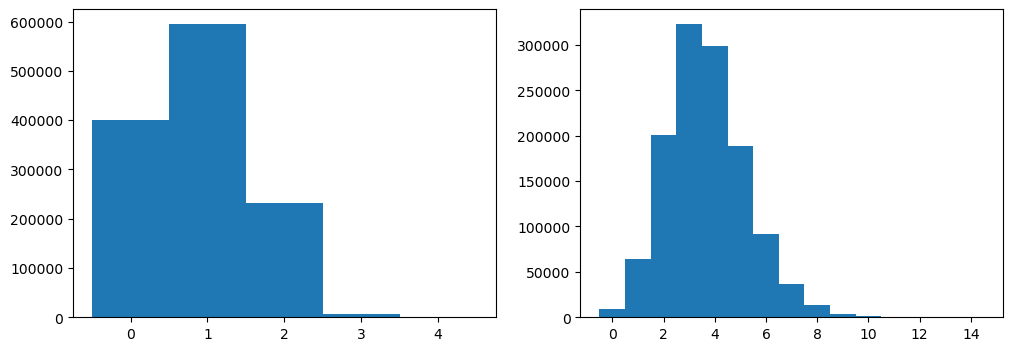

In [555]:
# Bellis edits

jet_kinematic_mask = (jets.pt > 20) & (np.abs(jets.eta) < 2.4)

jet_bjet_mask = (jets.btagDeepB > 0.8767)
jet_not_bjet_mask = (jets.btagDeepB < 0.5)

jets_b =     jets[jet_bjet_mask & jet_kinematic_mask]
jets_not_b = jets[jet_not_bjet_mask & jet_kinematic_mask]

n_bjets = ak.num(jets_b)
n_not_bjets = ak.num(jets_not_b)

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.hist(n_bjets, bins=5, range=(-0.5,4.5))
plt.subplot(1,2,2)
plt.hist(n_not_bjets, bins=15, range=(-0.5,14.5))

In [563]:
mask_numbers = (n_bjets >= 2) & (n_not_bjets >=2)

bjets_combos = ak.combinations(jets_b[mask_numbers], 2)
not_bjets_combos = ak.combinations(jets_not_b[mask_numbers], 2)

In [573]:
not_bjets_combos[1]['1']

<MomentumArray4D [{pt: 57.3, eta: -1.44, ...}, ...] type='3 * Momentum4D[pt...'>

In [569]:
bjets_combos['0'] 

<MomentumArray4D [[{pt: 131, eta: -0.976, ...}], ...] type='218566 * var * ...'>

In [574]:
bjets_combos['1']

<MomentumArray4D [[{pt: 25.8, eta: 0.942, ...}], ...] type='218566 * var * ...'>

In [503]:
# # Identifying jets in trijet that are bjets vs non-bjets
# is_bjet1 = (trijets.j1.btagDeepB > btag_cut) & (trijets.j2.btagDeepB < btag_cut) & (trijets.j3.btagDeepB < btag_cut)
# is_bjet2 = (trijets.j1.btagDeepB < btag_cut) & (trijets.j2.btagDeepB > btag_cut) & (trijets.j3.btagDeepB < btag_cut)
# is_bjet3 = (trijets.j1.btagDeepB < btag_cut) & (trijets.j2.btagDeepB < btag_cut) & (trijets.j3.btagDeepB > btag_cut)

# w_cand = ak.where(
#     is_bjet1, trijets.j2 + trijets.j3, # If j1 is a bjet then W = j2 + j3
#     ak.where(
#         is_bjet2, trijets.j1 + trijets.j3, # If j2 is the bjet then W = j1 + j3# Else j3 is the bjet so W = j1 + j2
#         trijets.j1 + trijets.j2 # Else j3 is the bjet so W = j1 + j2
#     )
# )

# w_mass = ak.flatten(w_cand.mass)


# w_trijet = trijets.p4[~mask_jets_btag][ak.argmax(trijets.p4.pt[~mask_jets_btag], axis=1, keepdims=True)]
# invmass_boson = ak.flatten(w_trijet.mass)



dijets_nb = dijets[non_mask_jets_btag]
mass_dif = abs(dijets_nb.p4.mass - 80.4)
w_cand_had2 = dijets_nb.p4[ak.argmin(mass_dif, axis = 1, keepdims=True)]
invmass_w2 = ak.flatten(w_cand_had2.mass)


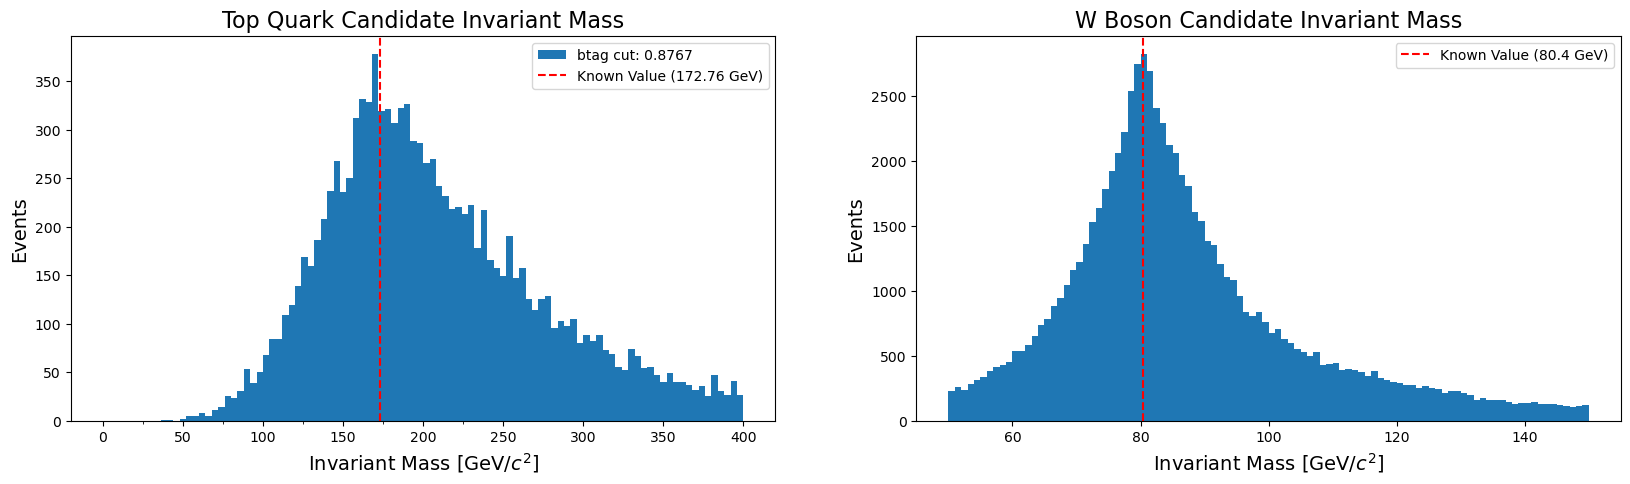

In [541]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Top Quark Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_top, bins=100, range=(0,400),label=f"btag cut: {btag_cut}")
plt.axvline(172.76,color="red",linestyle="--",label="Known Value (172.76 GeV)")

plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

plt.subplot(1,2,2)
plt.title("W Boson Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_w2, bins=100, range=(50,150))
plt.axvline(80.4,color="red",linestyle="--",label="Known Value (80.4 GeV)")

#plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

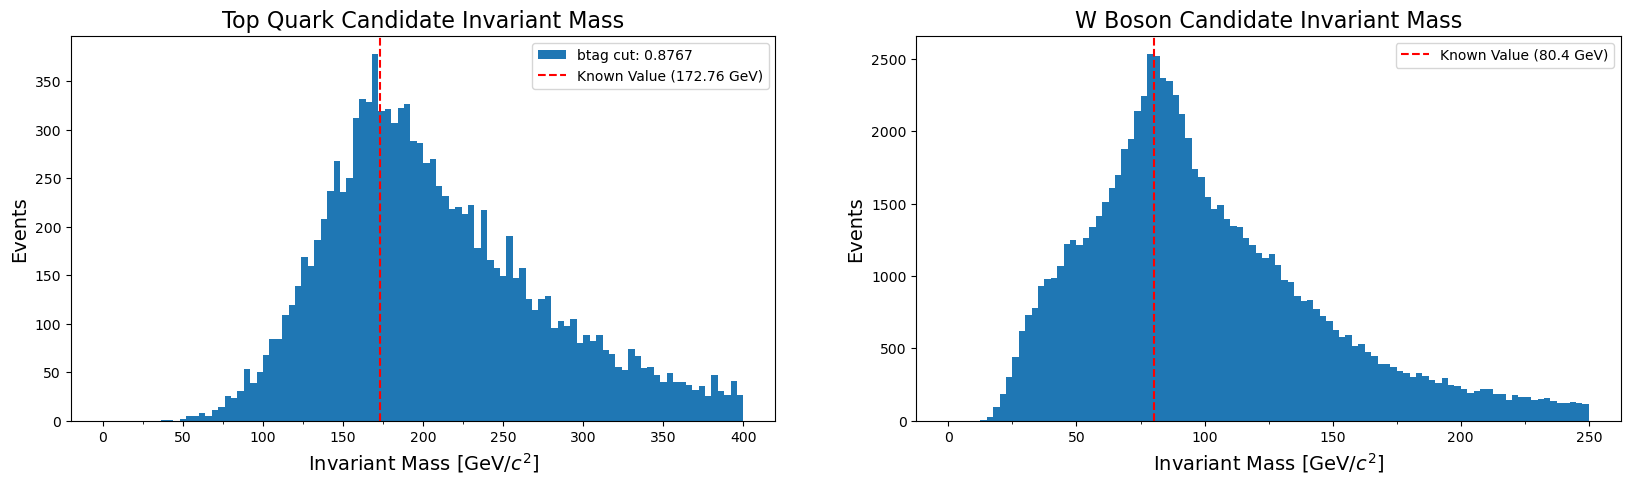

In [528]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Top Quark Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_top, bins=100, range=(0,400),label=f"btag cut: {btag_cut}")
plt.axvline(172.76,color="red",linestyle="--",label="Known Value (172.76 GeV)")

plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

plt.subplot(1,2,2)
plt.title("W Boson Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_w, bins=100, range=(0,250))
plt.axvline(80.4,color="red",linestyle="--",label="Known Value (80.4 GeV)")

plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

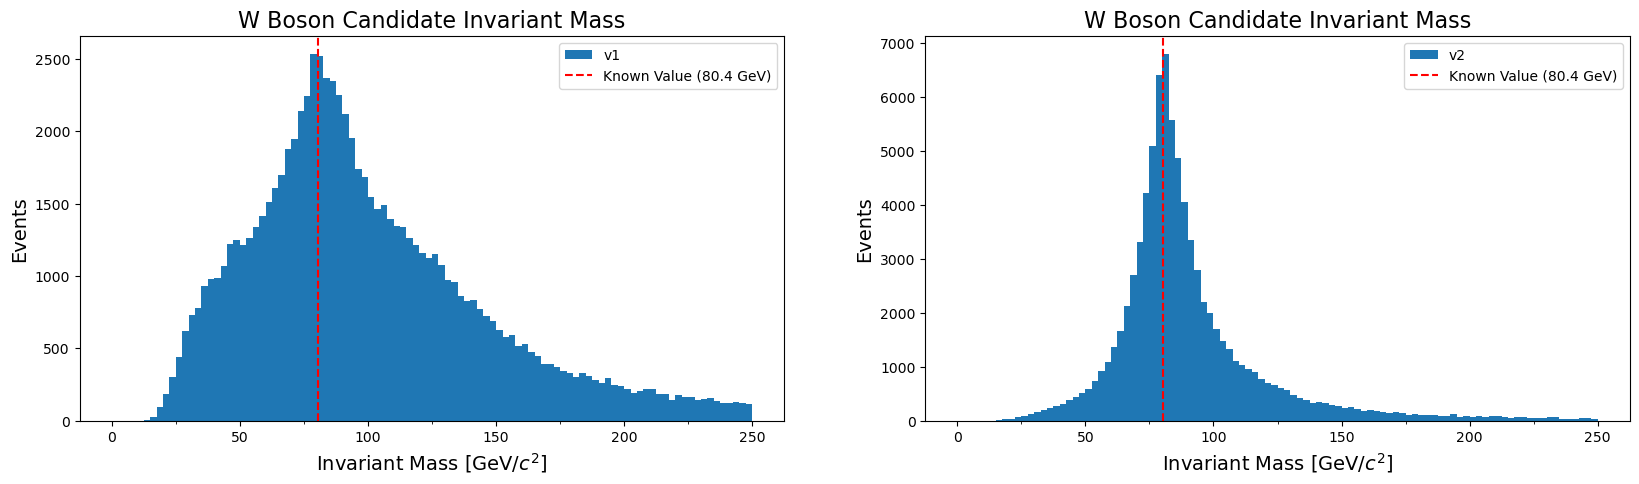

In [546]:
plt.figure(figsize=(20,5))


plt.subplot(1,2,1)
plt.title("W Boson Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_w, bins=100, range=(0,250), label="v1")
plt.axvline(80.4,color="red",linestyle="--",label="Known Value (80.4 GeV)")

plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

plt.subplot(1,2,2)
plt.title("W Boson Candidate Invariant Mass", fontsize=16)
plt.hist(invmass_w2, bins=100, range=(0,250), label="v2")
plt.axvline(80.4,color="red",linestyle="--",label="Known Value (80.4 GeV)")

plt.xticks(np.arange(0,275,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.legend();

In [499]:
btag_cut = 0.5
non_btag_cut = 0.2


mask1 = ((trijets.j1.btagDeepB > btag_cut) & (trijets.j2.btagDeepB < non_btag_cut) & (trijets.j3.btagDeepB < non_btag_cut))
mask2 = ((trijets.j1.btagDeepB < non_btag_cut) & (trijets.j2.btagDeepB > btag_cut) & (trijets.j3.btagDeepB < non_btag_cut))
mask3 = ((trijets.j1.btagDeepB < non_btag_cut) & (trijets.j2.btagDeepB < non_btag_cut) & (trijets.j3.btagDeepB > btag_cut))

mask = mask1 | mask2 | mask3

n = 2
for i in range(len(trijets[n].j1)):
    
    print('------------')
    print(trijets[n].j1[i])
    print(trijets[n].j2[i])
    print(trijets[n].j3[i])
    print()
    print(mask1[n])
    print(mask2[n])
    print(mask3[n])
    print(mask[n])

------------
{pt: 160, eta: -0.72, phi: 2.02, mass: 14.8, btagDeepB: 1, ...}
{pt: 77.2, eta: 1.21, phi: -1.54, mass: 11.6, btagDeepB: 1, ...}
{pt: 47.7, eta: 0.554, phi: -1.89, mass: 4.69, btagDeepB: 0.0703, ...}

[False, False, True, True]
[False, False, False, False]
[False, False, False, False]
[False, False, True, True]
------------
{pt: 160, eta: -0.72, phi: 2.02, mass: 14.8, btagDeepB: 1, ...}
{pt: 77.2, eta: 1.21, phi: -1.54, mass: 11.6, btagDeepB: 1, ...}
{pt: 36.6, eta: 0.251, phi: 0.564, mass: 6.32, btagDeepB: 0.0683, ...}

[False, False, True, True]
[False, False, False, False]
[False, False, False, False]
[False, False, True, True]
------------
{pt: 160, eta: -0.72, phi: 2.02, mass: 14.8, btagDeepB: 1, ...}
{pt: 47.7, eta: 0.554, phi: -1.89, mass: 4.69, btagDeepB: 0.0703, ...}
{pt: 36.6, eta: 0.251, phi: 0.564, mass: 6.32, btagDeepB: 0.0683, ...}

[False, False, True, True]
[False, False, False, False]
[False, False, False, False]
[False, False, True, True]
------------
{pt

# Leptonic Reconstruction of Top Quark

In [454]:
muons[muon_mask],met

(<MomentumArray4D [[], [], [{pt: 21.7, ...}], ..., [], []] type='1233000 * v...'>,
 <MomentumArray4D [{pt: 80.3, eta: 0, phi: ..., ...}, ...] type='1233000 * M...'>)

In [515]:
muon_mask = (muons.pt > 20) & (np.abs(muons.eta) < 2.1)
jet_mask = (jets.pt > 20) & (np.abs(jets.eta) < 2.4)
#met_mask = (met.pt > 20)

cut_muons = muons[muon_mask]
cut_jets = jets[jet_mask]
cut_met = met#[met_mask]

n_muons = ak.num(cut_muons)
n_jets = ak.num(cut_jets)
n_nonbjets = ak.sum(jets.btagDeepB < 0.8767, axis=1)
n_bjets = ak.sum(jets.btagDeepB > 0.8767, axis=1)


#event_mask = (n_muons == 1) & (n_jets == 4) & (n_nonbjets == 2)
event_mask2 = (n_muons >= 1) & (n_jets >= 4) & (n_bjets == 2) & (met.pt > 20)


#selected_nonbjets = cut_jets[event_mask]
selected_bjets = cut_jets[event_mask2]
selected_muons = cut_muons[event_mask2]
selected_met = cut_met[event_mask2]

# nonbjet = ak.zip(
#     {"px": selected_nonbjets[:,0].px,
#      "py": selected_nonbjets[:,0].py,
#      "pz": selected_nonbjets[:,0].pz,
#      "E":  selected_nonbjets[:,0].energy},
#     with_name="Momentum4D"
# )

bjet = ak.zip(
    {"px": selected_bjets[:,0].px,
     "py": selected_bjets[:,0].py,
     "pz": selected_bjets[:,0].pz,
     "E":  selected_bjets[:,0].energy},
    with_name="Momentum4D"
)

mu = ak.zip(
    {"px": selected_muons[:,0].px,
     "py": selected_muons[:,0].py,
     "pz": selected_muons[:,0].pz,
     "E":  selected_muons[:,0].energy},
    with_name="Momentum4D"
)

nu = ak.zip(
    {"px": selected_met.px,
     "py": selected_met.py,
     "pz": np.zeros(len(selected_met.py)),
     "E":  np.zeros(len(selected_met.py))},
    with_name="Momentum4D"
)

In [516]:
len(event_mask2[event_mask2])

77481

In [517]:
mu,nu

(<MomentumArray4D [{px: 12.8, py: -31, pz: -58, ...}, ...] type='77481 * Mom...'>,
 <MomentumArray4D [{px: -8.53, py: -42.8, ...}, ...] type='77481 * Momentum4...'>)

In [518]:
MW = 80.4 # GeV
mu_nu_p = mu.px*nu.px + mu.py*nu.py

Dtmp = MW**2 - mu.mass**2 + 2*(mu_nu_p)
Atmp = 4*(mu.energy**2 - mu.pz**2)
Btmp = -4 * Dtmp * mu.pz
Ctmp = 4 * mu.energy**2 * nu.pt**2 - Dtmp**2

disc = Btmp**2 - 4*Atmp*Ctmp

nu_pz1 = (-Btmp + np.sqrt(disc))/(2*Atmp)
nu_pz2 = (-Btmp - np.sqrt(disc))/(2*Atmp)

real_sol = disc >= 0

nu["pz"] = ak.where(real_sol,
    ak.where(abs(nu_pz1) < abs(nu_pz2), nu_pz1, nu_pz2),
                    -Btmp/(2*Atmp)
)

nu["E"] = np.sqrt(nu.px**2 + nu.py**2 + nu.pz**2)

In [519]:
w_cand_lep = mu + nu
w_cand_lep

<MomentumArray4D [{x: 4.28, y: -73.8, z: ..., ...}, ...] type='77481 * Mome...'>

In [520]:
w_cut = (w_cand_lep.mass > 80) & (w_cand_lep.mass < 81)
#w_cand_lep[w_cut].mass, bjet[w_cut].mass
top_cand_lep = w_cand_lep[w_cut] + bjet[w_cut]

In [521]:
print("W mass:", ak.to_numpy(w_cand_lep.mass)[:5])
print("bjet pt:", ak.to_numpy(bjet.pt)[:5])
print("top mass:", ak.to_numpy(top_cand_lep.mass)[:5])

W mass: [80.39999  80.39998  94.7069   80.4      94.713875]
bjet pt: [130.625 134.25  141.125  73.125 189.75 ]
top mass: [165.36902 372.38556 173.99948 406.80243 621.0326 ]


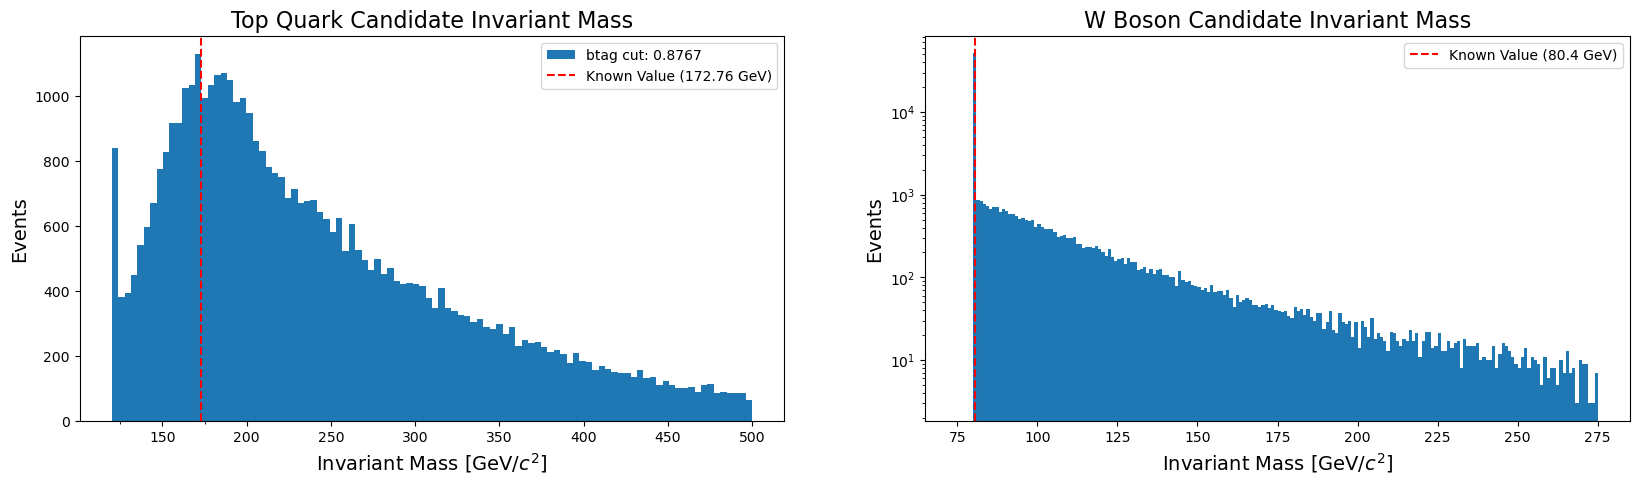

In [548]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Top Quark Candidate Invariant Mass",fontsize=16)
plt.hist(top_cand_lep.mass, bins=100, range=(120,500),label=f"btag cut: {btag_cut}")
plt.axvline(172.76,color="red",linestyle="--",label="Known Value (172.76 GeV)")

plt.xticks(np.arange(125,200,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]",fontsize=14)
plt.ylabel("Events",fontsize=14)
plt.legend();

plt.subplot(1,2,2)
plt.title("W Boson Candidate Invariant Mass",fontsize=16)
plt.hist(w_cand_lep.mass, bins=200, range=(75,275));
plt.axvline(80.4,color="red",linestyle="--",label="Known Value (80.4 GeV)")
plt.yscale('log')

#plt.xticks(np.arange(0,275,25),minor=True)
#plt.xlim(70,150)
plt.xlabel("Invariant Mass [GeV/$c^2$]",fontsize=14)
plt.ylabel("Events",fontsize=14)
plt.legend();

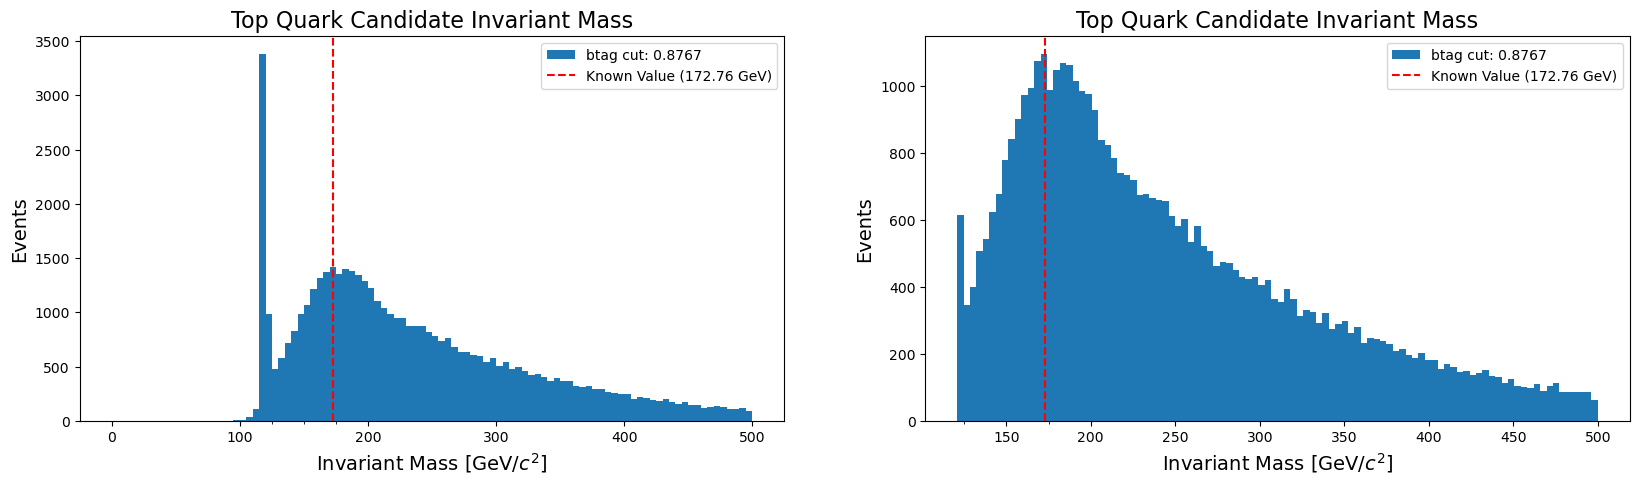

In [550]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Top Quark Candidate Invariant Mass",fontsize=16)
plt.hist(top_cand_lep.mass, bins=100, range=(0,500),label=f"btag cut: {btag_cut}")
plt.axvline(172.76,color="red",linestyle="--",label="Known Value (172.76 GeV)")

plt.xticks(np.arange(125,200,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]",fontsize=14)
plt.ylabel("Events",fontsize=14)
plt.legend();

plt.subplot(1,2,2)
plt.title("Top Quark Candidate Invariant Mass",fontsize=16)
plt.hist(top_cand_lep.mass, bins=100, range=(121,500),label=f"btag cut: {btag_cut}")
plt.axvline(172.76,color="red",linestyle="--",label="Known Value (172.76 GeV)")

plt.xticks(np.arange(125,200,25),minor=True)
plt.xlabel("Invariant Mass [GeV/$c^2$]",fontsize=14)
plt.ylabel("Events",fontsize=14)
plt.legend();